In [24]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product as product
%matplotlib notebook

In [25]:
def doobGillespie_v1(diagonal, diagonalDist, currState, Pjump, PjumpDist, biStates, N):
    """ Implements the rule where if the number of infectives increases by 10, social distancing
    is implemented and if the number of infectives drops below 5, social distancing is stopped"""
    distancing = False
    times = [(0, biStates[currState])]
    state = currState
    old = biStates[state][0] # num of susceps
    distancingTime = []
    while biStates[state][1] != 0: # While the number of infectives isn't zero
        if distancing:
            # print("distancing")
            timeSpent = np.random.exponential(scale=1/(diagonalDist[state]))
            state = np.random.choice(range(Pjump.shape[1]), p=PjumpDist[state, :])
            times.append((times[-1][0] + timeSpent, biStates[state]))
            if biStates[state][1] <= 5: # if the number of infectives goes below 5, relax restrictions
                distancing = False
                old = biStates[state][0]
                distancingTime.append(times[-1][0])
        else:     
            timeSpent = np.random.exponential(scale=1/(diagonal[state]))
            state = np.random.choice(range(Pjump.shape[1]), p=Pjump[state, :])
            times.append((times[-1][0] + timeSpent, biStates[state]))
            if old - biStates[state][0] >= 10:
                # print("start distancing")
                distancingTime.append(times[-1][0])
                distancing = True
                oldInf = biStates[state][1]
    return times, distancingTime

def doobGillespie_v2(diagonal, diagonalDist, currState, Pjump, PjumpDist, biStates, N):
    """ Implements the rule where if the number of infectives increases by 10, social distancing
    is implemented and ended only when the infection terminates"""
    distancing = False
    times = [(0, biStates[currState])]
    state = currState
    old = biStates[state][0] # num of susceps
    distancingTime = []
    while biStates[state][1] != 0: # While the number of infectives isn't zero
        if distancing:
            # print("distancing")
            timeSpent = np.random.exponential(scale=1/(diagonalDist[state]))
            state = np.random.choice(range(Pjump.shape[1]), p=PjumpDist[state, :])
            times.append((times[-1][0] + timeSpent, biStates[state]))
        else:     
            timeSpent = np.random.exponential(scale=1/(diagonal[state]))
            state = np.random.choice(range(Pjump.shape[1]), p=Pjump[state, :])
            times.append((times[-1][0] + timeSpent, biStates[state]))
            if old - biStates[state][0] >= 10:
                # print("start distancing")
                distancingTime.append(times[-1][0])
                distancing = True
                oldInf = biStates[state][1]
    return times, distancingTime

In [26]:
# Parameters
N = 100
I_0 = 5
Rsi = 2/N
Rir = 1/N

allStates = [(x, y) for x in range(N + 1) for y in range(N + 1) if x + y <= N]
states = {(x, y) : ind for ind, (x, y) in enumerate(allStates, 0)}
biStates = {ind : state for state, ind in states.items()}

In [27]:
def getQMatrix(states, ct=1):
    """ Obtains the Q-matrix for a particular ct value """
    Q = np.zeros((len(states), len(states)))

    for (x, y), ind in states.items():
        if y > 0:
            transitionTo = states[(x, y - 1)]
            Q[ind, transitionTo] = Rir * y
        if x > 0:
            transitionTo = states[(x - 1, y + 1)]
            Q[ind, transitionTo] = Rsi * y * x * ct
        Q[ind, ind] = - np.sum(Q[ind, :])
    
    diagonal = (- np.diagonal(Q))
    Pjump = Q / (- np.diagonal(Q))[:, np.newaxis]
    np.fill_diagonal(Pjump, 0)
    np.nan_to_num(Pjump, copy=False)
    return Q, Pjump, diagonal

# Q-matrix for when there is no social distancing
Q, Pjump, diagonal = getQMatrix(states)

#Q-matrix for when there is social distancing
DistQ, PjumpDist, diagonalDist = getQMatrix(states, ct=0.006)

C:\Users\Aviral\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


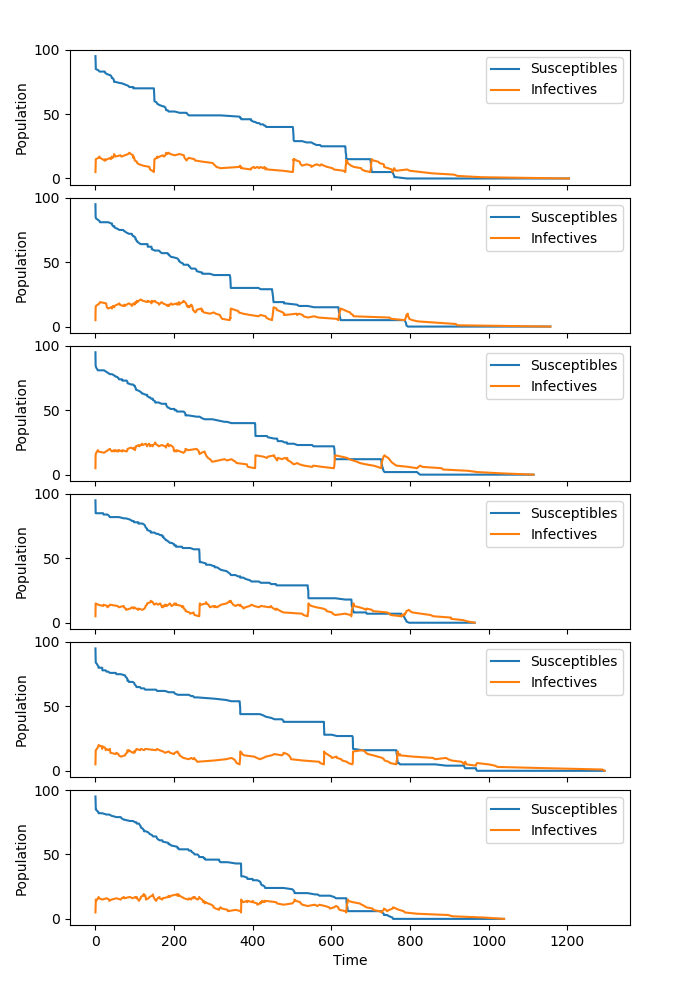

In [28]:
#### Example plots for the trajectory of the epidemic following strategy 1 ####
numFigures = 6
fig, ax = plt.subplots(nrows=numFigures, sharex=True, figsize=(7, 10))

for figNum in range(numFigures):
    trace, distancingTime = doobGillespie_v1(diagonal, 
                                             diagonalDist, states[(N - I_0, I_0)], 
                                             Pjump, PjumpDist, biStates, N)
    traceTimes, traceStates = zip(*trace)
    traceSuscep, traceInf = zip(*traceStates)

    # Plotting the trajectories
    ax[figNum].plot(traceTimes, traceSuscep, label="Susceptibles")
    ax[figNum].plot(traceTimes, traceInf, label="Infectives")

    ax[figNum].legend()
    ax[figNum].set_ylabel("Population")
    if figNum == (numFigures - 1):
        ax[figNum].set_xlabel("Time")

plt.subplots_adjust(top=0.95, bottom=0.075, hspace=0.1, left=0.1)
plt.savefig("images\\q6_i")

<IPython.core.display.Javascript object>


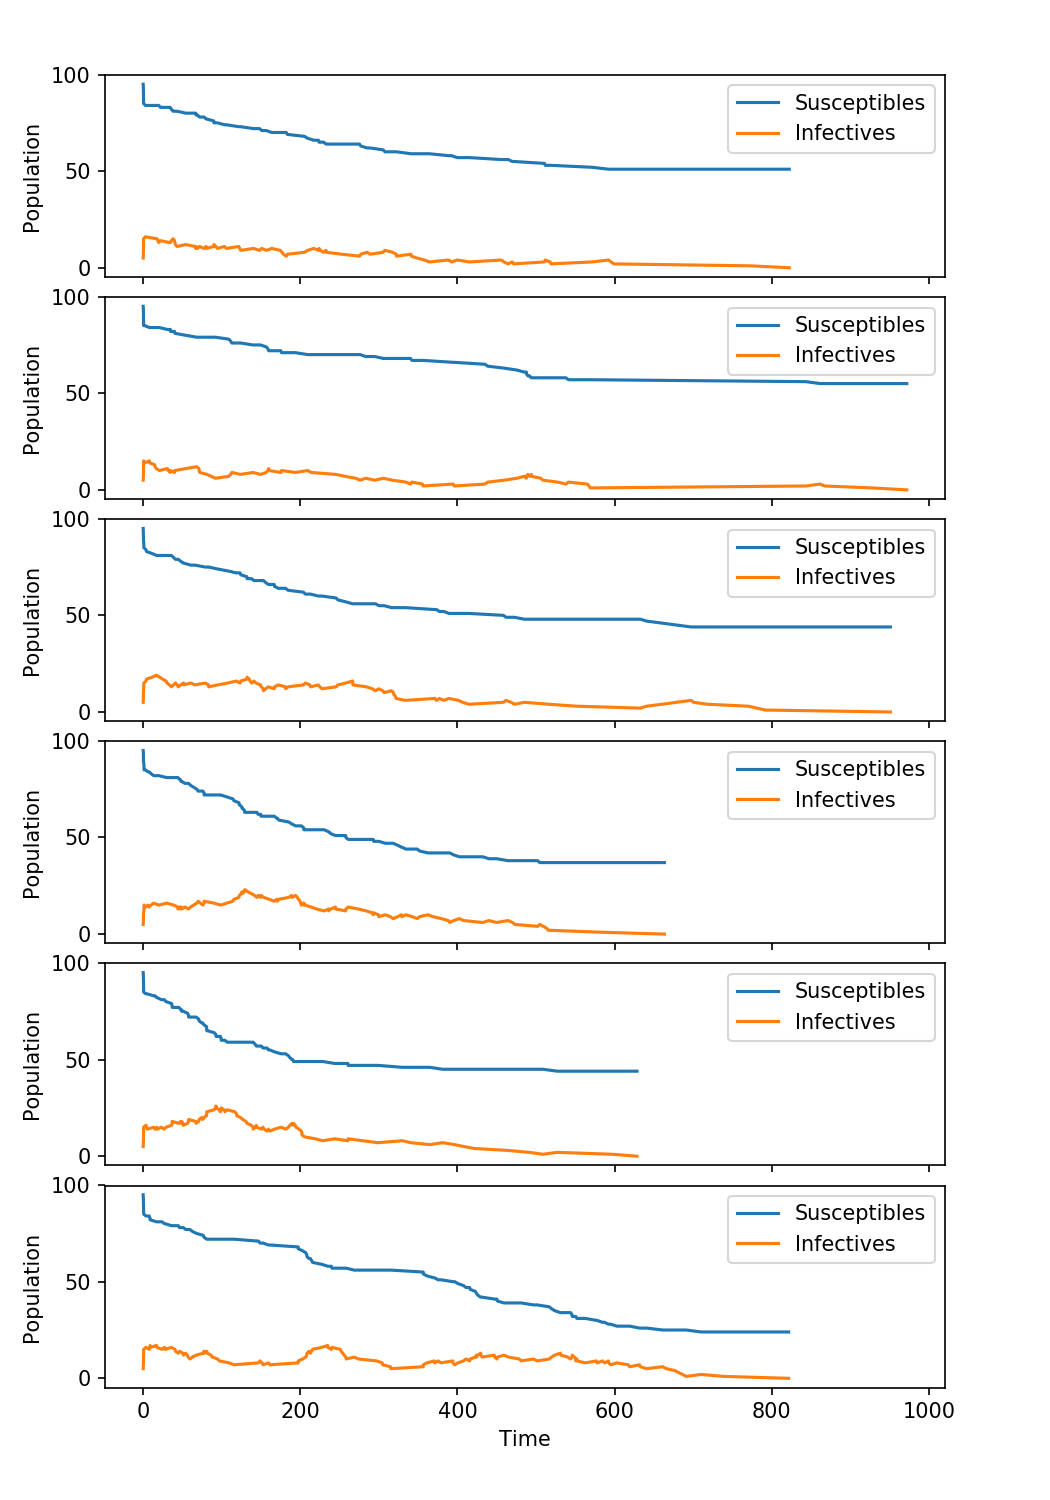

In [39]:
### Example plots for the trajectory of the epidemic following strategy 2 ###
numFigures = 6
fig, ax = plt.subplots(nrows=numFigures, sharex=True, figsize=(7, 10))

for figNum in range(numFigures):
    trace, distancingTime = doobGillespie_v2(diagonal, diagonalDist, 
                                             states[(N - I_0, I_0)], 
                                             Pjump, PjumpDist, biStates, N)
    traceTimes, traceStates = zip(*trace)
    traceSuscep, traceInf = zip(*traceStates)

    # Plotting the trajectories
    ax[figNum].plot(traceTimes, traceSuscep, label="Susceptibles")
    ax[figNum].plot(traceTimes, traceInf, label="Infectives")

    ax[figNum].legend()
    ax[figNum].set_ylabel("Population")
    if figNum == (numFigures - 1):
        ax[figNum].set_xlabel("Time")

plt.subplots_adjust(top=0.95, bottom=0.075, hspace=0.1, left=0.1)
plt.savefig("images\\q6_ii")

In [30]:
##### Obtaining distributions for P_n #####
funcs = [doobGillespie_v1, doobGillespie_v2]

distribution = np.zeros((len(funcs), N - I_0 + 1))

endTimes = [0, 0]

for func_ind, func in enumerate(funcs, 0):
    trials = int(5e4)
    infected = [0 for i in range(N - I_0 + 1)]
    # What does the distribution for this function look like
    for trial in range(trials):
        trace, _ = func(diagonal, diagonalDist, states[(N - I_0, I_0)], Pjump, PjumpDist, biStates, N)
        endState = trace[-1][1]
        endTimes[func_ind] += trace[-1][0]
        suscepInfected = (N - I_0) - endState[0]
        infected[suscepInfected] += 1
    
    distribution[func_ind, :] = np.asarray([i/trials for i in infected])
    endTimes[func_ind] /= trials

<IPython.core.display.Javascript object>


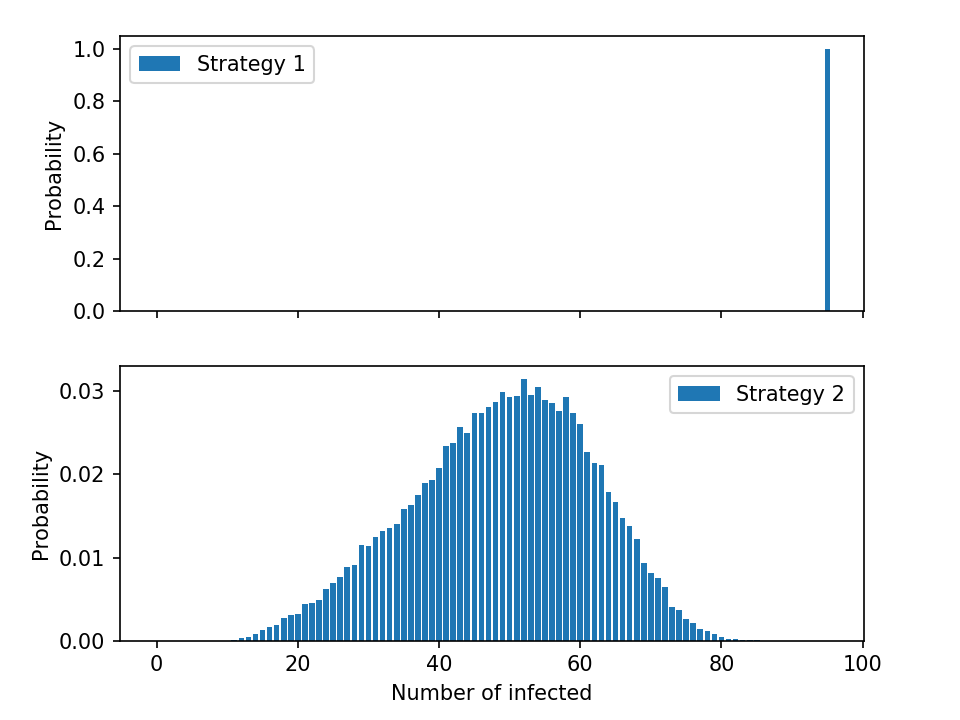

In [37]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].bar(range(N - I_0 + 1), distribution[0, :], label="Strategy 1")
ax[0].legend()
ax[0].set_ylabel("Probability")

ax[1].bar(range(N - I_0 + 1), distribution[1, :], label="Strategy 2")
ax[1].legend()
ax[1].set_xlabel("Number of infected")
ax[1].set_ylabel("Probability")
plt.subplots_adjust(top=0.95)
plt.savefig("images\\q6_iii")

In [33]:
sum(inf * prob for inf, prob in enumerate(distribution[1, :], 0))

48.88489999999999

In [35]:
endTimes

[1103.4303945607637, 718.2964161758889]